In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

In [2]:
def plot_variable_with_shapefiles(
    data, lon, lat, title, units, ax=None,
    cmap="RdBu_r", levels=21, shapefiles=None,
    extent=[65, 85, 0, 20], add_colorbar=True
):
    """
    Plots an ERA5 variable with shapefile overlay on a given axis (ax).

    Parameters:
        data : 2D numpy array
        lon, lat : 1D or 2D longitude/latitude arrays
        title : str
        units : str
        ax : matplotlib Axes (with Cartopy) — required for subplots
        cmap : str or Colormap
        levels : int or list of contour levels
        shapefiles : list of GeoDataFrames
        extent : [lon_min, lon_max, lat_min, lat_max]
        add_colorbar : bool (to control per-subplot or global colorbar)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    cf = ax.contourf(
        lon, lat, data,
        levels=levels,
        cmap=cmap,
        extend='both',
        transform=ccrs.PlateCarree()
    )

    if shapefiles:
        for shp in shapefiles:
            shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(title, fontsize=16)

    # Gridlines and ticks
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    gl.xlocator = plt.FixedLocator(np.arange(extent[0], extent[1]+1, 5))
    gl.ylocator = plt.FixedLocator(np.arange(extent[2], extent[3]+1, 5))

    if add_colorbar:
        cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
        cbar.set_label(units)
        cbar.ax.tick_params(labelsize=14)
    return cf  # so you can add a shared colorbar if needed


In [3]:
# Load shapefiles
wg = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")  # Western Ghats or region boundary
world = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")

# Ensure shapefiles are in WGS84
wg = wg.to_crs("EPSG:4326")
world = world.to_crs("EPSG:4326")

# Define bounding box: (minx, miny, maxx, maxy) = (lon_min, lat_min, lon_max, lat_max)
bbox = (65, 0, 85, 20)

# Clip using GeoDataFrame's .cx spatial indexer
world_clipped = world.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [4]:
# === CONFIG ===
clim_file = 'IMD_monthly_climatology.nc'
event_file = 'RF25_ind2024_rfp25.nc' 

ds_clim = xr.open_dataset(clim_file)
ds_event = xr.open_dataset(event_file)

july_rf = ds_clim.sel(TIME = 7)
rf_29 = ds_event.sel(time = '2024-07-30')
ano = rf_29['rf'].values - july_rf['RAINFALL'].values

lat = ds_event['lat'].values
lon = ds_event['lon'].values

/Users/subin/opt/anaconda3/envs/ipartpy3/lib/python3.7/site-packages/xarray/coding/times.py:123: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


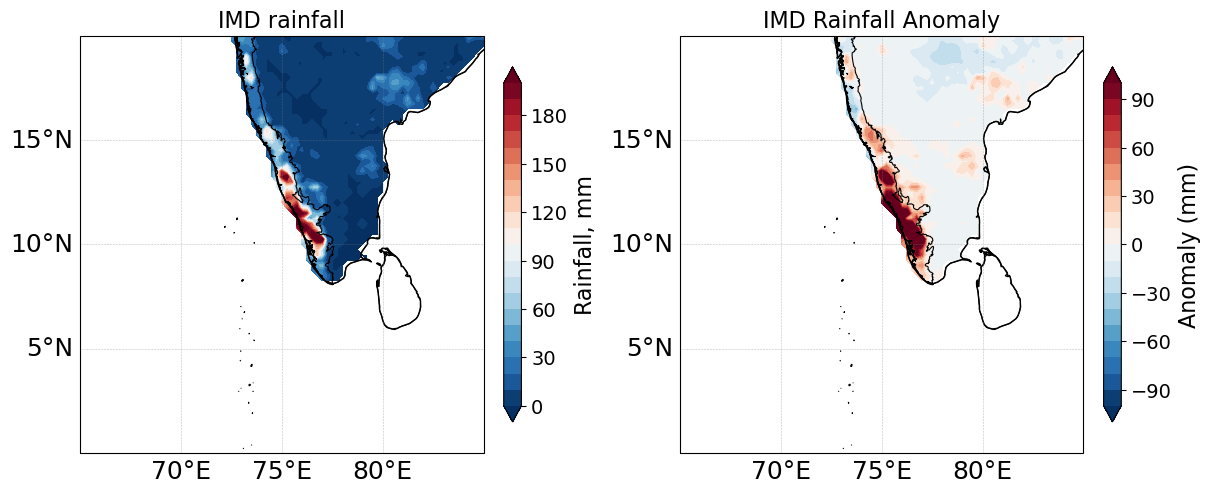

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(rf_29['rf'], lon, lat, "IMD rainfall", "mm", ax=axs[0],
                                    levels=np.linspace(0, 200, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
#cf2 = plot_variable_with_shapefiles(july_rf['RAINFALL'], lon, lat, "IMD rainfall July Climatology", "mm", ax=axs[1],
                                    #levels=np.linspace(0,200, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(ano, lon, lat, "IMD Rainfall Anomaly", "mm", ax=axs[1],
                                    levels=np.linspace(-100, 100, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
# Colorbars
cbar1 = fig.colorbar(cf1, ax=axs[0], orientation="vertical", shrink=0.6, pad=0.05)
cbar1.set_label("Rainfall, mm", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
#fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Rainfall, mm")
cbar3 = fig.colorbar(cf3, ax=axs[1], orientation="vertical", shrink=0.6, pad=0.05)
cbar3.set_label("Anomaly (mm)", fontsize=16)
cbar3.ax.tick_params(labelsize=14)
plt.savefig("IMD rainfall_30July2024_new1.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
rf_29_zonal_avg = rf_29.sel(lon = slice(73,77),lat= slice(8,13)).mean()
july_rf_zonal_avg = july_rf.sel(LONGITUDE = slice(73,77),LATITUDE= slice(8,13)).mean()

data = {'Parameter': ['rainfall'],
        'event': [rf_29_zonal_avg.values],
       'clim' : [july_rf_zonal_avg.values]}
df = pd.DataFrame(data)
print(df)

  Parameter                                              event  \
0  rainfall  <bound method Mapping.values of <xarray.Datase...   

                                                clim  
0  <bound method Mapping.values of <xarray.Datase...  
